In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
#from visualization import visualize, display, sequence_identity
from rdkit.Chem import AllChem
from scipy.stats import spearmanr, ttest_ind

import matplotlib as mpl
font = {'size' : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=1.5)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

def get_accuracy_level(predicted_ECs, true_ECs):
    """
    based on a list of predicted_ECs, calculates the highest level of accuracy achieved
    """
    #convert true_EC to a list
    if type(predicted_ECs) == str:
        predicted_ECs = [predicted_ECs]
        
    if type(true_ECs) == str:
        true_ECs = [true_ECs]

    maxes = []
    for true_EC in true_ECs:

        true_split = true_EC.split('.')
        
        counters = []
        for predicted_EC in predicted_ECs:
            #print(true_EC)
            predicted_split = predicted_EC.split('.')
            counter = 0
            
            for predicted, true in zip(predicted_split, true_split):
                if predicted == true:
                    counter += 1
                else:
                    break
            counters.append(counter)
            #print(counters)
        
        maxes.append(np.max(counters))
    return maxes
#import umap

#supress warnings
import warnings
warnings.filterwarnings("ignore")

### results must be processed into the correct format as csvs under `results_summary`

In [24]:
task1_baselines = ['Random', 'CLEAN']
task1_splits = ['30', '30-50', 'price', 'promiscuous']

task2_baselines = ['Random', 'Similarity', 'CREEP', 'CREEP_text']
task2_splits = ['easy', 'medium', 'hard']

reference_EC_list = np.loadtxt('processed_data/EC_list.txt', dtype=str)
num_ECs = len(reference_EC_list)

In [27]:
#find the column labeled as ['0']
def find_column(df, label):
    for i, col in enumerate(df.columns):
        if col == label:
            return i
    return None

In [28]:
#generate and save random EC rankings for each task and all splits
for task in ['task1', 'task2']:
    if task == 'task1':
        baselines = task1_baselines
        splits = task1_splits
        modality = 'protein'
    else:
        baselines = task2_baselines
        splits = task2_splits
        modality = 'reaction'

    for split in splits:
        query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baselines[1], split, modality))

        num_cols = find_column(query_df, '0')
        print(num_cols)

        for i in range(query_df.shape[0]):
            np.random.seed(42)
            #shuffle the columns
            query_df.iloc[i, num_cols:] = query_df.iloc[i, num_cols:].sample(frac=1).values
        
        query_df.to_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, 'Random', split, modality), index=False)

3
3
3
3
9


In [41]:
results = pd.DataFrame(columns=['baseline', 'split', 'k', 'level 4 accuracy', 'level 3 accuracy', 'level 2 accuracy', 'level 1 accuracy'])

#load the query_df that's already been generated
task  = 'task2'

if task == 'task1':
    baselines = task1_baselines
    splits = task1_splits
    modality = 'protein'
else:
    baselines = task2_baselines
    splits = task2_splits
    modality = 'reaction'

for baseline in baselines:
    for split in splits:

        query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baseline, split, modality)) #take a different baseline and randomize it
        if task == 'task1':
                num_cols = 3
        else:
            num_cols = len(query_df.columns) - num_ECs

        # query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baseline, split, modality))
        # num_cols = sum(isinstance(name, str) for name in query_df.columns)
        # print(num_cols)
        #query_df = query_df.iloc[141:142,:]

        #collapse columns 0:3 into a single column list
        for k in [1, 5, 10]:
            query_df['predicted ECs'] = query_df.iloc[:, num_cols:num_cols+k].values.tolist()
            query_df['EC number list'] = query_df['EC number'].apply(lambda x: x.split(';'))
            
            query_df['k={} accuracy level'.format(k)] = query_df.apply(lambda x: get_accuracy_level(x['predicted ECs'],  x['EC number list']), axis=1)

        #make a k=1 retrieval accuracy table, broken down by accuracy greater than or equal to level 1, 2, 3, 4

        for k in [1, 5, 10]:
            accuracies = []
            for i in [4, 3, 2, 1]:
                exploded = query_df.explode('k={} accuracy level'.format(k))
                accuracy = exploded[exploded['k={} accuracy level'.format(k)] >= i].shape[0] / exploded.shape[0]
                accuracies.append(round(accuracy*100, 1))
                
            results.loc[len(results)] = [baseline, split, k, accuracies[0], accuracies[1], accuracies[2], accuracies[3]]

In [42]:
results

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
0,Random,easy,1,0.0,0.0,0.6,13.6
1,Random,easy,5,0.0,0.6,6.2,50.8
2,Random,easy,10,0.0,4.5,18.1,82.5
3,Random,medium,1,0.0,1.1,1.7,16.4
4,Random,medium,5,0.0,2.3,11.3,57.1
5,Random,medium,10,0.0,4.5,23.7,83.6
6,Random,hard,1,0.0,1.2,1.2,24.5
7,Random,hard,5,0.0,3.7,4.3,48.5
8,Random,hard,10,0.0,6.7,11.0,73.6
9,Similarity,easy,1,60.5,78.0,87.0,93.2


In [43]:
results[results['k'] == 1].sort_values(by='split')

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
0,Random,easy,1,0.0,0.0,0.6,13.6
9,Similarity,easy,1,60.5,78.0,87.0,93.2
18,CREEP,easy,1,48.0,70.6,84.2,93.2
27,CREEP_text,easy,1,60.5,87.0,93.2,97.7
6,Random,hard,1,0.0,1.2,1.2,24.5
15,Similarity,hard,1,0.0,0.0,14.7,43.6
24,CREEP,hard,1,1.8,9.2,27.6,62.0
33,CREEP_text,hard,1,2.5,12.9,31.9,61.3
3,Random,medium,1,0.0,1.1,1.7,16.4
12,Similarity,medium,1,0.0,40.1,56.5,75.7


# TODO: UPDATE REST OF THIS NOTEBOOK
Visualization to better understand what is happening

### Measure similarity to existing embeddings

In [10]:
results = pd.DataFrame()
for split in ['easy', 'medium', 'hard']:
    reaction_similarities = np.load('/disk1/jyang4/repos/CARE/task2_baselines/Similarity/output/{}_split/retrieval_results/{}_reaction_test_reaction2reaction_retrieval_similarities.npy'.format(split, split))
    query_df = pd.read_csv('task2_baselines/results_summary/CREEP/{}_reaction_test_results_df.csv'.format(split))
    reference_df = pd.read_csv('splits/task2/{}_reaction_train.csv'.format(split))

    query_df['Correct'] = query_df['EC number'] == query_df['0']
    query_df['Similarity'] = np.max(reaction_similarities, axis=1)
    query_df = query_df.sort_values(by='Similarity', ascending=False)
    query_df['Split'] = split
    results = pd.concat([results, query_df], axis=0)
results

,Reaction,Mapped Reaction,EC number,Reaction Text,EC3,EC2,EC1,Duplicated EC,Reactions with a single EC,0,...,4666,4667,4668,4669,4670,4671,4672,Correct,Similarity,Split
79,CC(O)[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1cc...,[CH3:1][CH:2]([OH:3])[C@H:4]([NH:5][C:6](=[O:7...,2.7.14.1,ATP + a [protein]-L-arginine = ADP + a [protei...,2.7.14,2.70,2,True,1,2.7.11.19,...,3.1.1.1,3.1.1.105,2.1.1.278,4.2.1.105,2.1.1.50,4.2.99.23,4.2.99.22,False,1.0,easy
159,C/C(=C\C(=O)O)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(...,[CH3:1]/[C:2](=[CH:3]\[C:4](=[O:5])[OH:6])[C:7...,5.4.1.3,2-methylfumaryl-CoA = 3-methylfumaryl-CoA {r},5.4.1,5.40,5,True,1,5.4.1.3,...,3.2.1.49,3.2.1.123,3.5.1.101,2.4.1.68,3.5.1.105,3.2.1.99,3.5.1.125,True,1.0,easy
35,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[H+].[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C...,1.21.4.1,D-proline + NADH = 5-aminopentanoic acid + NAD+,1.21.4,1.21,1,True,1,1.21.4.1,...,3.1.1.57,5.3.99.11,4.1.3.32,4.99.1.8,6.5.1.4,6.5.1.5,2.4.1.290,True,1.0,easy
82,Nc1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@...,[NH2:1][c:2]1[cH:3][cH:4][n:5]([C@@H:6]2[O:7][...,2.7.4.10,CTP + AMP = CDP + ADP {r},2.7.4,2.70,2,True,1,2.7.4.8,...,3.1.1.75,3.1.1.87,3.1.1.72,3.1.1.1,3.1.1.73,4.2.99.23,4.2.99.22,False,1.0,easy
41,C=CC1=C(C)C(CC2=N/C(=C3\c4[nH]c(Cc5[nH]c(C=O)c...,[CH2:1]=[CH:2][C:3]1=[C:4]([CH3:5])[CH:6]([CH2...,1.3.7.12,primary fluorescent chlorophyll catabolite + N...,1.3.7,1.30,1,True,1,1.3.7.12,...,3.1.3.18,3.1.3.22,1.14.11.46,3.1.3.63,1.14.11.71,3.1.3.3,3.1.3.50,True,1.0,easy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,[CH3:1][C:2]([CH3:3])([CH2:4][O:5][P:6](=[O:7]...,1.2.7.4,propionyl-SCoA + CoASH = propionyl-SCoA + CoAS...,1.2.7,1.20,1,True,1,2.3.1.155,...,1.17.9.1,3.2.1.24,3.2.1.11,1.1.3.5,3.2.1.57,5.5.1.20,1.1.3.42,False,0.0,hard
128,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.99.1.9,protoporphyrin IX + Cu2+ = Cu-protoporphyrin I...,4.99.1,4.99,4,True,1,1.5.99.15,...,2.7.1.6,2.4.1.13,1.14.15.35,6.3.1.1,2.3.1.109,2.3.2.30,2.4.1.245,False,0.0,hard
127,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.98.1.1,Cd2+-protoporphyrin + H+ = protoporphyrin + Cd2+,4.98.1,4.98,4,True,1,3.5.4.27,...,2.4.1.245,2.3.1.183,2.3.1.271,2.3.1.53,2.7.1.157,2.3.1.109,2.3.2.30,False,0.0,hard
78,O.O=C(O)[C@H]1O[C@H](O[C@@H]2[C@H](O)[C@@H](O)...,[O:2]=[C:3]([OH:4])[C@H:5]1[O:6][C@H:7]([O:8][...,3.2.1.15,"alpha-D-galacturonosyl-(1,4)-O-alpha-D-galactu...",3.2.1,3.20,3,True,1,3.2.1.40,...,2.7.4.26,2.7.14.1,2.7.4.16,2.7.1.39,2.1.1.5,2.7.3.3,2.1.1.258,False,0.0,hard


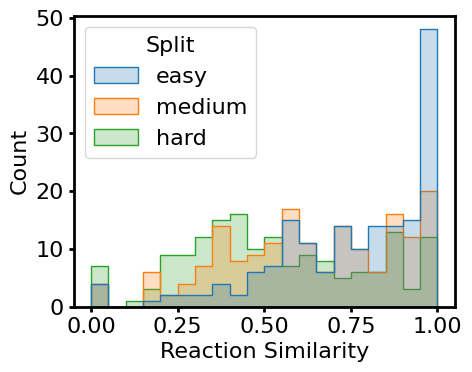

In [22]:
plt.figure(figsize=(5, 4))
sns.histplot(results, x='Similarity', hue='Split', element="step",stat="count", bins=20, fill=True)
sns.move_legend(plt.gca(), "upper left")
plt.xlabel('Reaction Similarity')
plt.tight_layout()
plt.savefig('generate_datasets_splits/figs/task2_similarity_histogram.png', dpi=500)

Ttest_indResult(statistic=1.8925318805665456, pvalue=0.06007117501288867)


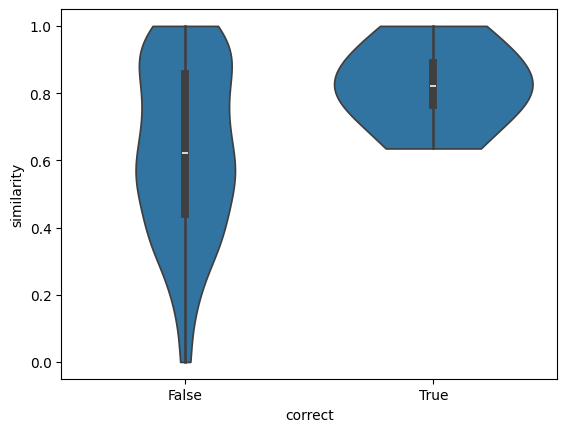

In [81]:
#calculate the correlation between correct and reaction similarity
#print(spearmanr(merged['reaction_similarity'],merged['correct']))
print(ttest_ind(query_df[query_df['correct']]['similarity'], query_df[~query_df['correct']]['similarity']))
sns.violinplot(data=query_df, x='correct', y='similarity', cut=False)

### Visualize some of the reactions with highest and lowest similarity

Something weird is going on here

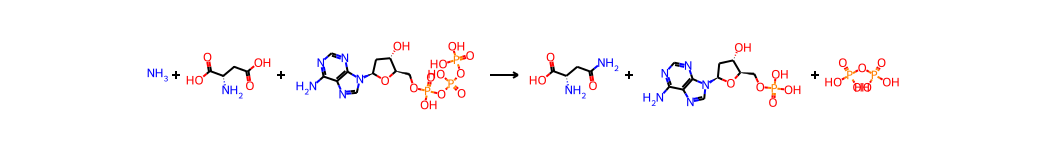

In [105]:
index=1
rxn = query_df['Reaction'].values[index]
EC_number = query_df['0'].values[index]
AllChem.ReactionFromSmarts(rxn, useSmiles=True)

In [106]:
EC_number

'6.3.1.1'

In [107]:
reference_subset = reference_df[reference_df['EC number'] == EC_number]
reference_subset

,Reaction,Mapped Reaction,EC number,Reaction Text,EC3,EC2,EC1,Duplicated EC,Reactions with a single EC
54955,N.N[C@@H](CC(=O)O)C(=O)O.Nc1ncnc2c1ncn2[C@@H]1...,[NH2:11][c:12]1[n:13][cH:14][n:15][c:16]2[c:17...,6.3.1.1,ATP + L-aspartate + NH3 = AMP + diphosphate + ...,6.3.1,6.3,6,False,2


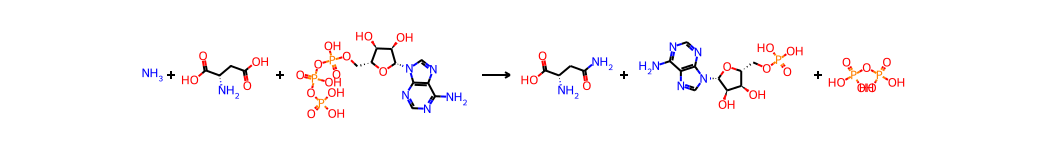

In [108]:
rxn2 = reference_subset['Reaction'].values[0]
AllChem.ReactionFromSmarts(rxn2, useSmiles=True) 

In [104]:
rxn ==  rxn2

False